<a href="https://colab.research.google.com/github/jcs-lambda/DS-Unit-2-Kaggle-Challenge/blob/master/jcspraul_DS_Sprint_Challenge_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Lambda School Data Science, Unit 2_

# Applied Modeling Sprint Challenge: Predict Chicago food inspections 🍕

For this Sprint Challenge, you'll use a dataset with information from inspections of restaurants and other food establishments in Chicago from January 2010 to March 2019. 

[See this PDF](https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF) for descriptions of the data elements included in this dataset.

According to [Chicago Department of Public Health — Food Protection Services](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_restaurants/svcs/food-protection-services.html), "Chicago is home to 16,000 food establishments like restaurants, grocery stores, bakeries, wholesalers, lunchrooms, mobile food vendors and more. Our business is food safety and sanitation with one goal, to prevent the spread of food-borne disease. We do this by inspecting food businesses, responding to complaints and food recalls." 

#### Your challenge: Predict whether inspections failed

The target is the `Fail` column.

- When the food establishment failed the inspection, the target is `1`.
- When the establishment passed, the target is `0`.

#### Run this cell to install packages in Colab:

In [0]:
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pandas-profiling==2.*
    !pip install pdpbox
    !pip install shap

#### Run this cell to load the data:

In [0]:
import pandas as pd

train_url = 'https://drive.google.com/uc?export=download&id=13_tP9JpLcZHSPVpWcua4t2rY44K_s4H5'
test_url  = 'https://drive.google.com/uc?export=download&id=1GkDHjsiGrzOXoF_xcYjdzBTSjOIi3g5a'

train = pd.read_csv(train_url)
test  = pd.read_csv(test_url)

assert train.shape == (51916, 17)
assert test.shape  == (17306, 17)

In [22]:
pd.DataFrame({
    'train_columns' : train.columns,
    'test_columns' : test.columns
})

,train_columns,test_columns
0,Inspection ID,Inspection ID
1,DBA Name,DBA Name
2,AKA Name,AKA Name
3,License #,License #
4,Facility Type,Facility Type
5,Risk,Risk
6,Address,Address
7,City,City
8,State,State
9,Zip,Zip


### Part 1: Preprocessing

You may choose which features you want to use, and whether/how you will preprocess them. If you use categorical features, you may use any tools and techniques for encoding.

_To earn a score of 3 for this part, find and explain leakage. The dataset has a feature that will give you an ROC AUC score > 0.90 if you process and use the feature. Find the leakage and explain why the feature shouldn't be used in a real-world model to predict the results of future inspections._

### Part 2: Modeling

**Fit a model** with the train set. (You may use scikit-learn, xgboost, or any other library.) Use cross-validation or do a three-way split (train/validate/test) and **estimate your ROC AUC** validation score.

Use your model to **predict probabilities** for the test set. **Get an ROC AUC test score >= 0.60.**

_To earn a score of 3 for this part, get an ROC AUC test score >= 0.70 (without using the feature with leakage)._


### Part 3: Visualization

Make visualizations for model interpretation. (You may use any libraries.) Choose two of these types:

- Confusion Matrix
- Permutation Importances
- Partial Dependence Plot, 1 feature isolation
- Partial Dependence Plot, 2 features interaction
- Shapley Values

_To earn a score of 3 for this part, make four of these visualization types._

## Part 1: Preprocessing

> You may choose which features you want to use, and whether/how you will preprocess them. If you use categorical features, you may use any tools and techniques for encoding.

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
import eli5
from eli5.sklearn import PermutationImportance
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot

In [23]:
train

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Violations,Latitude,Longitude,Location,Fail
0,2088270,"TOM YUM RICE & NOODLE, INC.",TOM YUM CAFE,2354911.0,Restaurant,Risk 1 (High),608 W BARRY,CHICAGO,IL,60657.0,2017-09-15T00:00:00,Canvass,3. POTENTIALLY HAZARDOUS FOOD MEETS TEMPERATUR...,41.938007,-87.644755,"{'longitude': '-87.6447545707008', 'latitude':...",1
1,555268,FILLING STATION & CONVENIENCE STORE,FILLING STATION & CONVENIENCE STORE,1044901.0,Grocery Store,Risk 3 (Low),6646-6658 S WESTERN AVE,CHICAGO,IL,60636.0,2011-10-20T00:00:00,Complaint Re-Inspection,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.772402,-87.683603,"{'longitude': '-87.68360273081268', 'latitude'...",0
2,1751394,A P DELI,A P DELI,47405.0,Restaurant,Risk 1 (High),2025 E 75TH ST,CHICAGO,IL,60649.0,2016-04-05T00:00:00,Canvass Re-Inspection,"35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTR...",41.758779,-87.575054,"{'longitude': '-87.57505446746121', 'latitude'...",0
3,1763905,FRANK'S CHICAGO SHRIMP HOUSE,FRANK'S CHICAGO SHRIMP HOUSE,6414.0,Restaurant,Risk 2 (Medium),4459 S ARCHER AVE,CHICAGO,IL,60632.0,2016-04-29T00:00:00,Canvass,38. VENTILATION: ROOMS AND EQUIPMENT VENTED AS...,41.812181,-87.707125,"{'longitude': '-87.70712481334274', 'latitude'...",0
4,453326,MORRILL,MORRILL,24571.0,School,Risk 1 (High),6011 S Rockwell (2600W) AVE,CHICAGO,IL,60629.0,2011-01-10T00:00:00,Canvass,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...",NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51911,1370030,VANILLE PATTISSERIE,VANILLE PATTISSERIE,2129404.0,Grocery Store,Risk 2 (Medium),131 N CLINTON ST,CHICAGO,IL,60661.0,2013-10-29T00:00:00,Canvass,NaN,41.884188,-87.641120,"{'longitude': '-87.64111966683218', 'latitude'...",0
51912,579387,CHICAGO STEAK HOUSE,CHICAGO STEAK HOUSE,2079910.0,Restaurant,Risk 2 (Medium),219 E 47TH ST,CHICAGO,IL,60653.0,2011-02-25T00:00:00,License Re-Inspection,NaN,41.809214,-87.620308,"{'longitude': '-87.62030817634384', 'latitude'...",0
51913,2169678,JEWEL FOOD STORE #3043,JEWEL FOOD STORE #3043,1144384.0,Grocery Store,Risk 1 (High),443 E 34TH ST,CHICAGO,IL,60616.0,2018-05-14T00:00:00,Canvass Re-Inspection,33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSI...,41.833045,-87.614611,"{'longitude': '-87.61461136443168', 'latitude'...",0
51914,1588969,RESTAURANTE SALVADORENO OLOCUILTA INC.,RESTAURANTE SALVADORENO OLOCUILTA,2308079.0,Restaurant,Risk 1 (High),3040 N LARAMIE AVE,CHICAGO,IL,60641.0,2015-11-30T00:00:00,Canvass Re-Inspection,NaN,41.936300,-87.756750,"{'longitude': '-87.75674980489909', 'latitude'...",0


leakage search:

if 'Violations' feature contains 1-29, which are considered critical or serious violations (according to the pdf linked above)

they are much more likely (>90%) to fail vs. the baseline (26%)

the violations feature contains information from the 'future' in terms of predicting whether or not an inspection resulted in a failure.

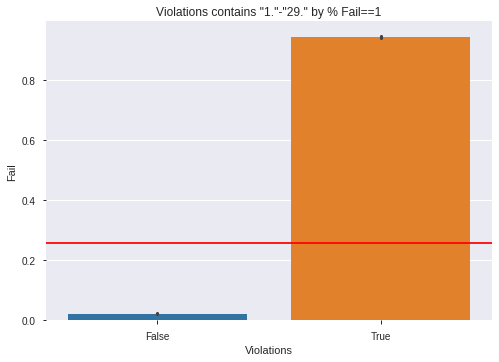

In [117]:
sns.barplot(
    x = train['Violations'].str.contains('[^3-9][0-9][.]'),
    y = train['Fail'] == 1
)
plt.title('Violations contains "1."-"29." by % Fail==1')
plt.axhline(y=train['Fail'].value_counts(normalize=True)[1], color='red')
plt.show()

In [7]:
def my_describe(dataframe, formatter={'all':lambda x : f'{x}'}):
  def len_minified(series):
    if not series.dtype == 'O':
      return series.nunique()
    return series.fillna('').str.lower().str.replace('[^a-z0-9]', '').nunique()
 
  data = pd.DataFrame({
      'type' : dataframe.dtypes,
      'total' : dataframe.count() + dataframe.isnull().sum(),
      'present' : dataframe.count(),
      'null' : dataframe.isnull().sum(),
      'nunique' : dataframe.nunique(),
      'minified_nunique' : [len_minified(pd.Series(dataframe[column].unique())) for column in dataframe.columns],
      'unique' : [np.array2string(dataframe[column].unique(), separator=', ', formatter=formatter)[1:-1] for column in dataframe.columns]
  })

  if (data['nunique'] == data['minified_nunique']).all(): data.drop(columns='minified_nunique', inplace=True)
  return data

my_describe(train)

,type,total,present,null,nunique,minified_nunique,unique
Inspection_ID,int64,51916,51916,0,51916,51916,"2088270, 555268, 1751394, ..., 2169678, 158896..."
DBA_Name,object,51916,51916,0,17049,16535,"TOM YUM RICE & NOODLE, INC., FILLING STATION ..."
AKA_Name,object,51916,51293,623,16350,15861,"TOM YUM CAFE, FILLING STATION & CONVENIENCE ..."
License_#,float64,51916,51911,5,21421,21421,"2354911.0, 1044901.0, 47405.0, ..., 2570316.0,..."
Facility_Type,object,51916,51692,224,329,285,"Restaurant, Grocery Store, School, Long Term C..."
Risk,object,51916,51904,12,3,4,"Risk 1 (High), Risk 3 (Low), Risk 2 (Medium), nan"
Address,object,51916,51916,0,13954,13884,"608 W BARRY , 6646-6658 S WESTERN AVE , 2025 E..."
City,object,51916,51863,53,39,37,"CHICAGO, nan, LAKE BLUFF, BEDFORD PARK, chicag..."
State,object,51916,51906,10,1,2,"IL, nan"
Zip,float64,51916,51890,26,86,86,"60657.0, 60636.0, 60649.0, 60632.0, 60629.0, 6..."


In [0]:
def my_value_counts(dataframe, features):
  if type(features) is not list:
    features = [features]
  for feature in features:
    df = pd.DataFrame({
        'count' : dataframe[feature].value_counts().sort_index(),
        'percentage' : dataframe[feature].value_counts(normalize=True).sort_index()
    })
    df.index.name = feature
    display(df.sort_values(by='count', ascending=False))

In [9]:
target = 'Fail'

my_value_counts(train, target)

,count,percentage
Fail,,
0,38490,0.74139
1,13426,0.25861


In [14]:
def normalize(column):
  return pd.DataFrame({
      'original' : column,
      'normalized' : column.fillna('').str.lower().str.replace('[^a-z0-9]', '')
  })

norm = normalize(train['Inspection_Type'])
for column in norm.columns:
  print(column, norm[column].unique())

original ['Canvass' 'Complaint Re-Inspection' 'Canvass Re-Inspection'
 'License Re-Inspection' 'License' 'Complaint' 'Short Form Complaint'
 'Special Events (Festivals)' 'Consultation' 'Task Force Liquor 1475'
 'Tag Removal' 'Complaint-Fire' 'License-Task Force'
 'Suspected Food Poisoning Re-inspection' 'Out of Business'
 'Complaint-Fire Re-inspection' 'TASK FORCE LIQUOR 1470'
 'Suspected Food Poisoning' 'Recent Inspection' 'NO ENTRY'
 'Short Form Fire-Complaint' 'KIDS CAFE' 'No Entry' 'no entry'
 'Pre-License Consultation' 'Package Liquor 1474'
 'TASK FORCE LIQUOR (1481)' 'Illegal Operation'
 'LICENSE RENEWAL FOR DAYCARE' 'CANVASS SPECIAL EVENTS'
 'CHANGED COURT DATE' 'TAVERN 1470' 'Non-Inspection'
 'TWO PEOPLE ATE AND GOT SICK.' 'Not Ready'
 'CLOSE-UP/COMPLAINT REINSPECTION' 'SMOKING COMPLAINT'
 'LICENSE WRONG ADDRESS' 'OUT OF BUSINESS' 'CANVASS/SPECIAL EVENT'
 'RECALL INSPECTION' nan 'POSSIBLE FBI' 'License consultation'
 'SPECIAL TASK FORCE' 'SFP/Complaint' 'LICENSE DAYCARE 1586' '

In [25]:
train.columns

Index(['Inspection ID', 'DBA Name', 'AKA Name', 'License #', 'Facility Type',
       'Risk', 'Address', 'City', 'State', 'Zip', 'Inspection Date',
       'Inspection Type', 'Violations', 'Latitude', 'Longitude', 'Location',
       'Fail'],
      dtype='object')

In [0]:
def wrangle(dataframe):
  df = dataframe.copy()

  df['Inspection Date'] = pd.to_datetime(df['Inspection Date'], infer_datetime_format=True, errors='coerce')

  columns_to_drop = ['Inspection ID', 'DBA Name', 'AKA Name', 'License #', 'Address', 'State', 'Violations', 'Inspection Date', 'Location']
  df = df.drop(columns=columns_to_drop)

  df['Zip'] = df['Zip'].fillna(0).astype(int).astype(str).str.replace('^0$', '00000')

  categoricals_to_normalize = ['Facility Type', 'City', 'Inspection Type']
  for categorical in categoricals_to_normalize:
    df[categorical] = df[categorical].fillna('').str.lower().str.replace('[^a-z0-9]', '')
  

  return df

In [31]:
df_train, df_test = map(wrangle, [train, test])

df_train.shape, df_test.shape

((51916, 8), (17306, 8))

In [32]:
df_train.isnull().sum()

Facility Type        0
Risk                12
City                 0
Zip                  0
Inspection Type      0
Latitude           198
Longitude          198
Fail                 0
dtype: int64

In [35]:
df_train.nunique()

Facility Type        285
Risk                   3
City                  37
Zip                   87
Inspection Type       47
Latitude           13410
Longitude          13410
Fail                   2
dtype: int64

In [37]:
df_train.dtypes

Facility Type       object
Risk                object
City                object
Zip                 object
Inspection Type     object
Latitude           float64
Longitude          float64
Fail                 int64
dtype: object

In [39]:
cardinality = df_train.select_dtypes(exclude='number').nunique()
low_cardinality = cardinality[cardinality < 50].index.tolist()
low_cardinality

['Risk', 'City', 'Inspection Type']

## Part 2: Modeling

> **Fit a model** with the train set. (You may use scikit-learn, xgboost, or any other library.) Use cross-validation or do a three-way split (train/validate/test) and **estimate your ROC AUC** validation score.
>
> Use your model to **predict probabilities** for the test set. **Get an ROC AUC test score >= 0.60.**

In [0]:
features = df_train.columns.drop([target])

X_train = df_train[features]
X_test = df_test[features]

y_train = df_train[target]
y_test = df_test[target]

In [0]:
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats.distributions import randint, uniform

In [42]:
pipeline = make_pipeline(
    ce.OneHotEncoder(cols=low_cardinality, use_cat_names=True),
    ce.OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(random_state=13, n_jobs=-1)
)

param_distributions = {
    'simpleimputer__strategy' : ['mean', 'median', 'most_frequent'],
    'randomforestclassifier__n_estimators' : randint(25,250),
    'randomforestclassifier__max_depth' : [None, 10, 20, 50, 100],
    'randomforestclassifier__min_samples_split' : randint(2, 10),
    'randomforestclassifier__min_samples_leaf' : randint(1, 10),
    'randomforestclassifier__max_features' : uniform(0, 1),
}

search = RandomizedSearchCV(
    estimator = pipeline,
    param_distributions = param_distributions,
    n_iter = 15,
    scoring = 'roc_auc',
    n_jobs = -1,
    cv = 4,
    random_state = 13,
    verbose = 10,
).fit(X_train, y_train)

Fitting 4 folds for each of 15 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   51.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  8.3min finished


In [43]:
best_score = search.best_score_
best_pipeline = search.best_estimator_
best_params = search.best_params_

print(f'Best CV roc_auc score: {best_score}')
print(f'using paramters: {best_params}')

Best CV roc_auc score: 0.704339708229321
using paramters: {'randomforestclassifier__max_depth': 20, 'randomforestclassifier__max_features': 0.19683160689262624, 'randomforestclassifier__min_samples_leaf': 7, 'randomforestclassifier__min_samples_split': 9, 'randomforestclassifier__n_estimators': 232, 'simpleimputer__strategy': 'most_frequent'}


In [61]:
y_pred_proba = best_pipeline.predict_proba(X_test)[:,1]
test_roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f'Test roc_auc: {test_roc_auc}')

Test roc_auc: 0.7120206256756832


In [62]:
test_score = search.score(X_test, y_test)

print(f'Test roc_auc: {test_score}')

Test roc_auc: 0.7120206256756832


## Part 3: Visualization

> Make visualizations for model interpretation. (You may use any libraries.) Choose two of these types:
>
> - Permutation Importances
> - Partial Dependence Plot, 1 feature isolation
> - Partial Dependence Plot, 2 features interaction
> - Shapley Values

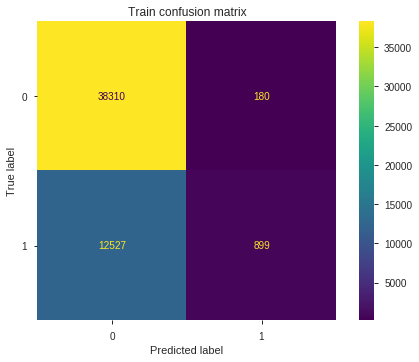

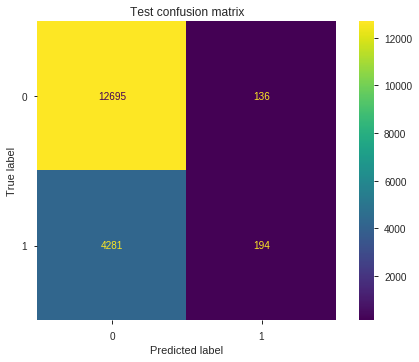

In [69]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(best_pipeline, X_train, y_train, values_format='.0f')
plt.title('Train confusion matrix')
plt.grid(False)
plt.show()

plot_confusion_matrix(best_pipeline, X_test, y_test, values_format='.0f')
plt.title('Test confusion matrix')
plt.grid(False)
plt.show()

In [110]:
permuter_transforms = make_pipeline(
    best_pipeline.named_steps['onehotencoder'],
    best_pipeline.named_steps['ordinalencoder'],
    best_pipeline.named_steps['simpleimputer']
)

model = best_pipeline.named_steps['randomforestclassifier']

X_train_transformed = pd.DataFrame(permuter_transforms.fit_transform(X_train), columns=permuter_transforms.named_steps['ordinalencoder'].feature_names)
X_test_transformed = pd.DataFrame(permuter_transforms.transform(X_test), columns=permuter_transforms.named_steps['ordinalencoder'].feature_names)

feature_names = X_train_transformed.columns.tolist()

permuter = PermutationImportance(
    estimator = model,
    scoring = 'roc_auc',
    n_iter = 3,
    random_state = 13,
    cv = None,
).fit(X_test_transformed, y_test)

eli5.show_weights(
    estimator = permuter,
    top = None,
    feature_names = feature_names
)

Weight,Feature
0.0731 ± 0.0020,Latitude
0.0675 ± 0.0019,Longitude
0.0592 ± 0.0012,Inspection Type_license
0.0495 ± 0.0038,Inspection Type_canvassreinspection
0.0397 ± 0.0002,Zip
0.0369 ± 0.0006,Facility Type
0.0331 ± 0.0024,Inspection Type_complaint
0.0242 ± 0.0022,Inspection Type_canvass
0.0186 ± 0.0018,Risk_Risk 1 (High)
0.0172 ± 0.0014,Inspection Type_licensereinspection


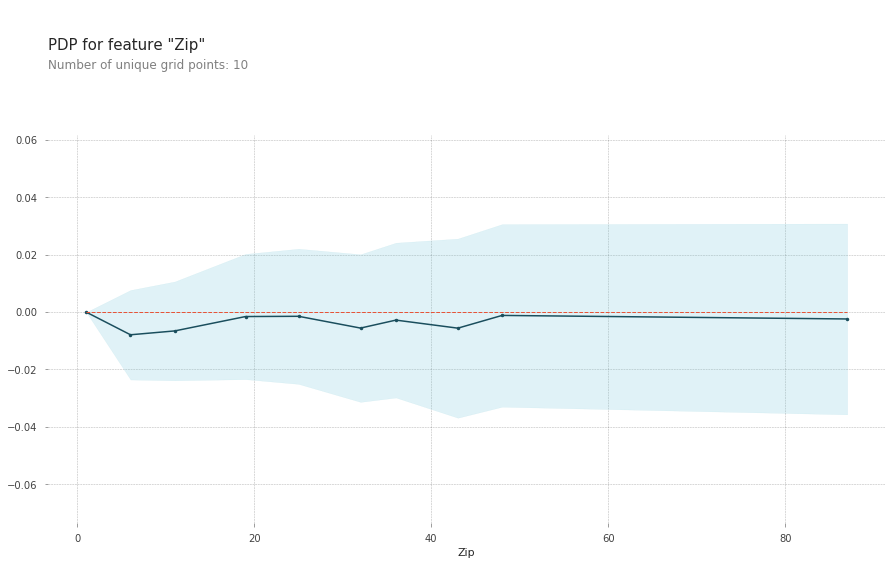

In [81]:
feature = 'Zip'

isolated = pdp_isolate(
    model = model,
    dataset = X_train_transformed,
    model_features = feature_names,
    feature = feature
)

pdp_plot(isolated, feature, );

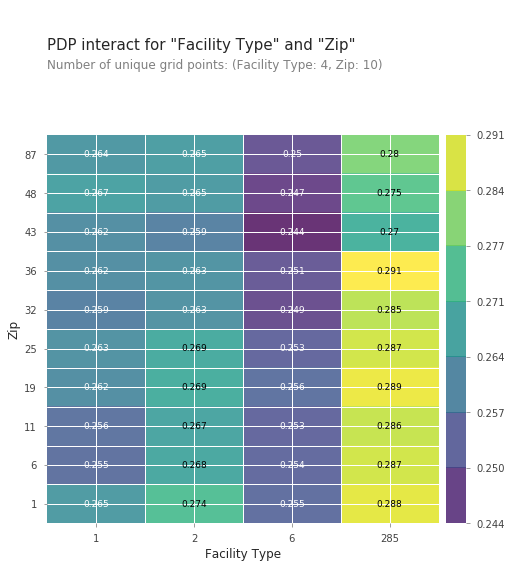

In [84]:
interact_features = ['Facility Type', 'Zip']

interaction = pdp_interact(model, X_train_transformed, feature_names, interact_features)

pdp_interact_plot(interaction, interact_features, 'grid')
plt.grid(False)
plt.show()

In [108]:
which_test_observation = 45

row = X_test_transformed.iloc[[which_test_observation]]
actual = test.iloc[[which_test_observation]]['Fail'].iloc[0]
predicted = model.predict(row)[0]

print(f'Acutal target value for row: {actual}')
print(f'Predicted target value for row: {predicted}')

Acutal target value for row: 0
Predicted target value for row: 0


In [109]:
import shap
from IPython.display import display

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(row)

shap.initjs()

for i in range(len(explainer.expected_value)):
  display(shap.force_plot(explainer.expected_value[i], shap_values[i], row, out_names=f'Fail=={i}'))